In [1]:
%pylab inline
# coding=utf-8

import tek3 # import tek3 as tek3 : utilidades de comunicación con Tek2002B
import time # import time
tds2002b = tek3.TekScope("/dev/usbtmc1") # creo una instancia de tek3.TekScope

# refresca lo importado de tek3 cada vez que se hace ejecución
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
TEKTRONIX,TDS 2002B,C101891,CF:91.1CT FV:v22.11


# Registro automático de picos

In [2]:
def initPulse(inst=test):
    inst.write('INITIATE_CLEAR')
    inst.write('HEADER OFF')
    inst.set_data_encoding('RIBinary')
    inst.write('ACQuire:MODe SAMple') # test.write('ACQuire:MODe PEAKdetect') lo descarto pues manual dice que puede verse mas ruidoso  
    inst.write('ACQUIRE:STOPAFTER SEQUENCE')
    inst.write('ACQuire:STATE RUN')
    inst.write('CH1:POSition 3.0')
    inst.write('CH1:SCAle 2E-2')
    inst.write('CH2:POSition -2.0')
    inst.write('CH2:SCAle 2E-1')
    inst.horizontal_main_position(1.0E-7)
    inst.horizontal_main_scale(1.0E-7)
    inst.trigger_source('CH1')
    trgLevel= -0.08
    test.trigger_level(trgLevel)
    
    
def escalas(inst=test):
    # obtener una vez los límites verticales del canal
    pos1 = inst.get_channel_position(1)
    scale1 = inst.get_channel_scale(1)
    pos2 = inst.get_channel_position(2)
    scale2 = inst.get_channel_scale(2)
    return pos1, scale1, pos2, scale2


def flName(camara, tipo, N):
    filePath= './data/'
    fileDate= time.strftime('%y%m%d')
    fileCamara= camara # 'n' nuestra = Campbelliana
    fileN= N
    fileExt= '.npy'
    fileType= tipo
    fileName= filePath+ fileType+ fileDate + fileCamara+ ('{:02n}'.format(fileN))+ fileExt
    return fileName

def param(osciloscopioTek):
    '''
    Grabo parámetros de la medición
    '''
    osciloscopioTek.load_setup() # Obtiene parámetros del osciloscopio
    sets= osciloscopioTek.dico
    [pos1, scale1, pos2, scale2]= escalas(osciloscopioTek)
    sets['POSITION1']= pos1
    sets['SCALE1']= scale1
    sets['POSITION2']= pos2
    sets['SCALE2']= scale2
    sets['ELECTRONICA']= 'Luis'
    return sets


def paramSave(N, camara='CFP-25'):
    '''
    Grabo parámetros de la medición
    '''
    sets= param(camara)
    save(flName(camara, 'sets', N), sets)
    
    
def eins(channel):
    ''' 
    Returns single channel as horizontal array 
    '''
    test.set_data_source(channel)
    Y= float16(test.bin_read())
    return Y


def readBuff2(self):
    try:
        return self.ask('CURVE?')
    except TimeoutError:
        print('Probably requested channel has no data')
        raise
        
        
def zwei():
    '''
    Returns both channels as horizontal array
    '''
    Y1= eins(1)
    Y2= eins(2)
    Meas2= np.vstack([Y1, Y2])
    return Meas2


def single():
    '''
    Queries both channels, restarts acquistion
    '''
    test.start_acq()
    Meas2= zwei()
    return Meas2


def darstellungNurZwei(T, Meas2, sav= None):
    '''
    T: times vector
    Meas2: Both channels 2D array
    sav: plot filename (eps)
    '''
        
    fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
    fig.set_size_inches(10,8)
    fig.subplots_adjust(hspace=0.000)

    ax0.plot(T, Meas2[0,:], 'y')
    # Make the y-axis label and tick labels match the line color.
    ax0.set_ylabel('ch 1 [V]', color='y')
    ax0.grid(True)

    ax1.plot(T, Meas2[1,:], 'c')
    ax1.set_ylabel('ch 2 [V]', color='c')
    ax1.set_xlabel('tiempo [s]')
    ax1.grid(True)
    
    if (sav):
        plt.savefig('./data/'+ sav+ '.eps')
    else:
        plt.show()
        
        
def darstellungNurZwei(T, Meas2, sav= None):
    '''
    T: times vector
    Meas2: Both channels 2D array
    sav: plot filename (eps)
    '''
        
    fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
    fig.set_size_inches(10,8)
    fig.subplots_adjust(hspace=0.000)

    ax0.plot(T, Meas2[0,:], 'y')
    # Make the y-axis label and tick labels match the line color.
    ax0.set_ylabel('ch 1 [V]', color='y')
    ax0.grid(True)

    ax1.plot(T, Meas2[1,:], 'c')
    ax1.set_ylabel('ch 2 [V]', color='c')
    ax1.set_xlabel('tiempo [s]')
    ax1.grid(True)
    
    if (sav):
        plt.savefig('./data/'+ sav+ '.eps')
    else:
        plt.show()
        
        
def acqDartellung(nombre, inst=test, graf=False):
    zeit= tek3.TekScope.Xaxis(inst)
    data= zeit
    print('\n')
    for count in range(nombre): #
        while(test.textAsk('BUSY?')=='1'):
            time.sleep(.5)
        M2= single()
        data= np.vstack([data,M2])
        if (graf):
            darstellungNurZwei(zeit, M2)
        print('\rN= '+ str(count+ 1), end=' ')
    print('\n')
    return data


def prom(data, prop):
    '''
    (array, float) -> array
    
    Obtiene el promedio de la primer fracción prop de ambos canales de todas las mediciones en data
    grProm[0]: ch1, grProm[1]: ch2

    '''
    messungenZahl= data.shape
    erstePunkten= int(messungenZahl[1]* prop)
    prom= np.zeros([int((messungenZahl[0]- 1)/ 2), 2])
    for i in range(1, messungenZahl[0], 2):
        ix= int((i-1)/2)
        prom[ix,0]= (data[i][0:erstePunkten-1]).mean()
        prom[ix,1]= (data[i+1][0:erstePunkten-1]).mean()
    grProm= np.array([ (prom[:,0]).mean(), (prom[:,1]).mean() ])
    return grProm


class archie:
    """Nombre archivo - NO FUNCA AUN, NO PUEDO VARIAR EXTERNAMENTE tipo"""

    def __init__(self, tipo, N, camara):
        """ (archie, int, str, str, str) -> NoneType

        Un nombre de archivo con ruta, cámara, fecha y número 

        >>> archie = CashRegister(5, 5, 5, 5, 5)
        >>> archie.N
        '5'
        >>> archie.camara
        'n'
        >>> archie.path
        './data/'
        >>> register.date
        '150430'
        """
        self.tipo= tipo
        self.N=('{:02n}'.format(N))
        self.camara = camara
        self.path = './data/'
        self.date = time.strftime('%y%m%d')
        self.ext= '.npy'
        self.fileName= self.tipo+ self.date+ self.camara+ self.N+ self.ext

# Lectura rápida, graba ints comprimidos

In [3]:
def ptsAdq():
    # correr una vez para obtener parámetros del buffer
    buff2 = readBuff2(test) # esta bien la herencia?
    dataPointsCharacters= int(buff2[1:2])
    dataOffset= 2+ dataPointsCharacters
    return (int(buff2[2:2+ dataPointsCharacters])), dataOffset # número de lecturas en cada adquisición


def rapi(dataCount, dataOffset):
    test.start_acq()
    while(test.textAsk('BUSY?')=='1'):
        time.sleep(1E-3)
    # return (np.frombuffer(readBuff2(test), dtype = np.dtype('int8').newbyteorder('<'), count= dataCount, offset= dataOffset) )  
    buff2 = readBuff2(test) # esta bien la herencia?
    return ( np.frombuffer(buff2, dtype = np.dtype('int8').newbyteorder('<'), count= dataCount, offset= dataOffset) )


def lectura(adquisiciones, puntosAdquisicion, dataOffset, tiempoInicial):
    # la lectura en sí
    ch1= np.empty([adquisiciones,puntosAdquisicion], dtype ='int8')
    ch2= np.empty([adquisiciones,puntosAdquisicion], dtype ='int8')
    zeit= test.temps() # zeit
    # zeit= tek3.TekScope.Xaxis(test) # zeit
    for medicion in range(adquisiciones):
        print('\rmedición '+ str(medicion)+ ' de '+ str(adquisiciones), end=' ')
        test.set_data_source(1) # canal 2
        ch1[medicion]= rapi(puntosAdquisicion, dataOffset)
        test.set_data_source(2) # canal 2
        ch2[medicion]= rapi(puntosAdquisicion, dataOffset)
    print('\rmedición '+ str(medicion+ 1)+ ' de '+ str(adquisiciones))
    print('Tiempo transcurrido= {:.1f} min'.format((time.time()- tiempoInicial)/60) ) # tiempo transcurrido en segundos
    return zeit, ch1, ch2


def adquiere(medicionDia, settings, adquisiciones, descripcionDetector, descripcionArchivo, puntosAdquisicion, dataOffset, trgLevel= -0.058):
    '''
    registra ambos canales en formato de multiples arrays
    '''

    tiempoInicial= time.time()

    # ch2 =lectura(adquisiciones, puntosAdquisicion, dataOffset, tiempoInicial)
    [zeit, ch1, ch2]= lectura(adquisiciones, puntosAdquisicion, dataOffset, tiempoInicial)
    
    # PULSER INVIERTO SIGNO CH1: Mantengo el ánalisis imperturbado
    ch1*= -1

    # graba    
    np.savez_compressed(flName(descripcionDetector, descripcionArchivo, medicionDia), settings=settings, zeit=zeit, ch1=ch1, ch2=ch2)

# Consulta al osciloscopio del estado actual

In [4]:
[ch1S, ch1p, ch2s, ch2p, hS, hP, trig]= [tds2002b.get_channel_scale('CH1'), tds2002b.get_channel_position('CH1'), tds2002b.get_channel_scale('CH2'), tds2002b.get_channel_position('CH2'), tds2002b.horizontal_main_scale(), tds2002b.horizontal_main_position(), tds2002b.trigger_level()]
[ch1S, ch1p, ch2s, ch2p, hS, hP, trig]

[0.02, 3.0, 0.01, 0.0, '1.0E-7', '3.16E-7', -0.04]

# Adquisición con generador de pulsos

In [5]:
# Secuencia principal
tds2002b.write('INITIATE_CLEAR')
tds2002b.write('HEADER OFF')
tds2002b.set_data_encoding('RIBinary')
tds2002b.write('ACQuire:MODe SAMple') # test.write('ACQuire:MODe PEAKdetect') lo descarto pues manual dice que puede verse mas ruidoso  
tds2002b.write('ACQUIRE:STOPAFTER SEQuence')
tds2002b.write('ACQuire:STATE RUN')
tds2002b.write('CH1:COUPling DC')
tds2002b.write('CH2:COUPling DC')

In [6]:
# generador pulsos
tds2002b.write('CH1:SCAle 0.02')
tds2002b.write('CH1:POSition 3.0')
tds2002b.write('CH2:SCAle 0.01')
tds2002b.write('CH2:POSition 0.0')
tds2002b.horizontal_main_scale(1.0E-7)
tds2002b.horizontal_main_position(3.16E-7)
tds2002b.trigger_source('CH1')
tds2002b.trigger_level(-0.04) # [V]

In [7]:
settings= param(tds2002b)
[puntosAdquisicion, dataOffset] = ptsAdq(tds2002b) # puntos por cada adquisición, headbits en cada adquisición

descripcionDetector= 'z'
descripcionArchivo= 'pul'
adquisiciones= 1*1280 # número de lecturas

TypeError: ptsAdq() takes 0 positional arguments but 1 was given

In [ ]:
for medicionDia in np.arange(1,2): # medición 1 a 2 (dos mediciones)
    adquiere(medicionDia, settings, adquisiciones, descripcionDetector, descripcionArchivo, puntosAdquisicion, dataOffset)

# Ensayos

In [10]:
test.write('HEADER OFF')

### Lectura simple

In [11]:
settings= param()
settings

{':HARDCOPY:BUTTON': 'SAVESALL',
 ':MATH:FFT:VERTICAL:POSITION': '0.0E0',
 ':CURSOR:VBARS:UNITS': 'SECONDS',
 'STOPAFTER': 'SEQUENCE',
 ':DISPLAY:FORMAT': 'YT',
 ':TRIGGER:MAIN:MODE': 'NORMAL',
 'SOURCE': 'CH2',
 ':MEASUREMENT:MEAS5:TYPE': 'FREQUENCY',
 'STATE': '0',
 'INKSAVER': 'ON',
 'COUPLING': 'DC',
 ':VERBOSE': '1',
 'CURRENTPROBE': '1.0E1',
 'IDPRINT': 'DEFLT',
 'DATEPRINT': 'DEFLT',
 'FORMAT': 'EPSIMAGE',
 ':CH1:PROBE': '1.0E0',
 'LAYOUT': 'PORTRAIT',
 'SOURCE1': 'CH1',
 'DESTINATION': 'REFA',
 ':PICTBRIDGE:PAPERSIZE': 'DEFLT',
 ':HORIZONTAL:VIEW': 'MAIN',
 ':ACQUIRE:MODE': 'SAMPLE',
 ':AUTORANGE:SETTINGS': 'BOTH',
 'BANDWIDTH': 'OFF',
 ':SAVE:IMAGE:FILEFORMAT': 'EPSIMAGE',
 ':LANGUAGE': 'SPANISH',
 'WIDTH:POLARITY': 'POSITIVE',
 'YUNIT': '"V"',
 'TYPE': 'EDGE',
 ':MEASUREMENT:MEAS1:TYPE': 'PK2PK',
 'SYNC': 'FIELD',
 'STYLE': 'VECTORS',
 'CH2': '1',
 'WIDTH': '1.0E-3',
 'STOP': '2500',
 'PERSISTENCE': '0',
 ':MEASUREMENT:MEAS2:TYPE': 'PERIOD',
 'STANDARD': 'NTSC',
 ':CURSOR:HBA

In [6]:
np.float(settings['POSITION1'])

NameError: name 'settings' is not defined

In [7]:
[puntosAdquisicion, dataOffset] = ptsAdq() # puntos por cada adquisición, headbits en cada adquisición
[zeit, ch1, ch2]=lectura(1, puntosAdquisicion, dataOffset, 0)

ValueError: invalid literal for int() with base 10: b'C'

In [18]:
cosaCh1= ((4/100)* ch1[0]- np.float(settings['POSITION1']) )* np.float(settings['SCALE1'])
cosaCh2= ((4/100)* ch2[0]- np.float(settings['POSITION2']) )* np.float(settings['SCALE2'])

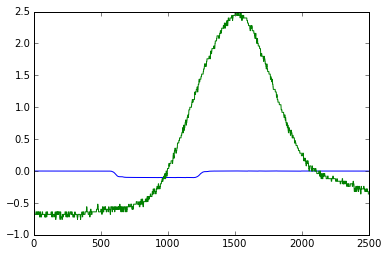

In [19]:
plt.plot(cosaCh1)
plt.plot(cosaCh2)

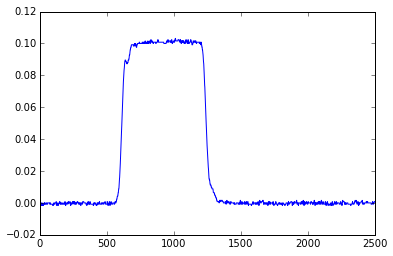

In [83]:
ch1_nega= ch1[0]* (-1)
cosa_nega= ((4/100)* ch1_nega+ np.float(settings['POSITION1']) )* np.float(settings['SCALE1'])
plt.plot(cosa_nega)

## Análisis

In [6]:
test.get_channel_scale('CH1'), test.get_channel_position('CH1'), test.get_channel_scale('CH2'), test.get_channel_position('CH2'), test.horizontal_main_scale(), test.horizontal_main_position(), test.trigger_level()

(0.02, 2.0, 0.5, -2.0, '1.0E-7', '2.56E-7', -0.0496)

In [5]:
settings= param()

In [7]:
test.horizontal_main_scale()

'1.0E-7'

In [4]:
test.horizontal_main_position()

'2.0E-7'

In [6]:
test.horizontal_main_position(2.0E-7)
test.horizontal_main_scale(1.0E-7)

In [8]:
test.write('INITIATE_CLEAR')
test.set_data_encoding('RIBinary')
test.write('ACQuire:MODe SAMple') # test.write('ACQuire:MODe PEAKdetect') lo descarto pues manual dice que puede verse mas ruidoso  
test.write('ACQUIRE:STOPAFTER SEQUENCE')
test.write('ACQuire:STATE RUN')
test.write('CH1:POSition 3.0')
test.write('CH1:SCAle 5E-2')
test.write('CH2:POSition -3.0')
test.write('CH2:SCAle 2E-1')
test.horizontal_main_position(2.0E-7)
test.horizontal_main_scale(1.0E-7)
test.trigger_source('CH1')
trgLevel= -0.1
test.trigger_level(trgLevel)

In [13]:
[puntosAdquisicion, dataOffset] = ptsAdq() # puntos por cada adquisición, headbits en cada adquisición

In [9]:
test.get_channel_scale('CH1'), test.get_channel_position('CH1')

(0.02, 3.0)

In [18]:
aou=13
aou*=-1
aou

-13

In [12]:
test.write('CH1:POSition 4.0')


In [13]:
test.write('INITIATE_CLEAR')
test.set_data_encoding('RIBinary')
test.write('ACQuire:MODe SAMple') # test.write('ACQuire:MODe PEAKdetect') lo descarto pues manual dice que puede verse mas ruidoso  
test.write('ACQUIRE:STOPAFTER SEQUENCE')
test.write('ACQuire:STATE RUN')
test.write('CH1:SCAle 0.02')
test.write('CH1:POSition 4.0')
test.write('CH2:SCAle 0.5')
test.write('CH2:POSition -2.0')
test.horizontal_main_scale(1.0E-7)
test.horizontal_main_position(0)
trgLevel= -0.05
test.trigger_source('CH1')
test.trigger_level(trgLevel)

# adquisiciones= 1280 # número de lecturas
adquisiciones= 1 # número de lecturas

descripcionDetector= 'z'
descripcionArchivo= 'pul'

settings= param()
[puntosAdquisicion, dataOffset] = ptsAdq() # puntos por cada adquisición, headbits en cada adquisición

for medicionDia in np.arange(1,2): # medición 1 a 2 (dos mediciones)
    adquiere(medicionDia, settings, adquisiciones, descripcionDetector, descripcionArchivo, puntosAdquisicion, dataOffset)

medición 1 de 1
Tiempo transcurrido= 0.0 min


In [17]:
test.get_out_waveform_horizontal_zero()

-4.96e-07

In [19]:
test.horizontal_main_position('0')

In [20]:
test.horizontal_main_position()

'0.0E0'

In [21]:
test.horizontal_main_scale()

'1.0E-7'

In [37]:
xincr= test.textAsk('WFMPre:XINcr?')
xincr

'4.0E-10'

In [36]:
xzero= test.textAsk('WFMPre:XZEro?')
xzero

'-5.0E-7'

In [30]:
float(xzero)+ 2500*float(xincr)

5e-07

In [31]:
float(xzero)+ 1*float(xincr)

-4.996e-07

In [33]:
test.get_horizontal_record_length()

2500

In [34]:
tiempos= [1,2]

In [35]:
tiempos[0]

1

In [53]:
temps=float(xzero)+arange(2500)*float(xincr)
temps[0]

-4.9999999999999998e-07

In [52]:
temps[2497]

4.988000000000001e-07

In [54]:
temps[2499]

4.9960000000000016e-07

In [55]:
np.round(temps[2499],3)

0.0

In [59]:
print('%s'.format(temps[2499]))

%s


In [69]:
print('{:4.2e}'.format(temps[2499]))

5.00e-07


In [ ]:
def temps(self):
    xincr= self.get_out_waveform_horizontal_sampling_interval()
    xzero= self.get_out_waveform_horizontal_zero()
    lesTemps= xzero+ np.arange(2500)* xincr
    return lesTemps

In [21]:
test.get_out_waveform_horizontal_sampling_interval()

4e-10